In [9]:
%cd /Users/masha/Documents/visual-reasoning

/Users/masha/Documents/visual-reasoning


In [11]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import timm
import cv2
import random

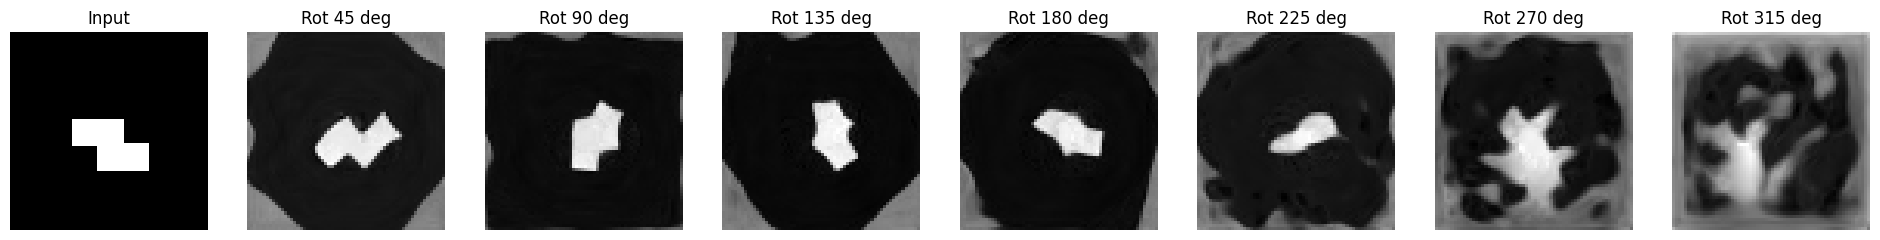

In [ ]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
MODEL_PATH = "models/rotator_l2_100e_10k.pth"

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class FastRotator(nn.Module):
    def __init__(self, backbone_dim=384, flow_dim=32):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4))
        self.angle_mlp = nn.Sequential(nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4))
        self.cond_proj = nn.Linear(backbone_dim, flow_dim*4)

        self.inc = DoubleConv(1, flow_dim)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(flow_dim, flow_dim*2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(flow_dim*2, flow_dim*4))

        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = DoubleConv(flow_dim*6, flow_dim*2)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = DoubleConv(flow_dim*3, flow_dim)

        self.outc = nn.Conv2d(flow_dim, 1, kernel_size=1)

    def forward(self, x_t, t, dino_emb, target_angle_deg):
        t_emb = self.time_mlp(t)
        d_emb = self.cond_proj(dino_emb)
        a_emb = self.angle_mlp(target_angle_deg / 360.0)
        global_cond = (t_emb + d_emb + a_emb).unsqueeze(-1).unsqueeze(-1)

        x1 = self.inc(x_t)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x3 = x3 + global_cond

        x = self.conv1(torch.cat([self.up1(x3), x2], dim=1))
        x = self.conv2(torch.cat([self.up2(x), x1], dim=1))
        return self.outc(x)

model = FastRotator().to(DEVICE)
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(MODEL_PATH)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

dino = timm.create_model("vit_small_patch16_dinov3", pretrained=True).to(DEVICE).eval()

def get_dino_embedding(img_64_tensor):
    img = (img_64_tensor * 0.5) + 0.5
    img = F.interpolate(img, size=(224, 224), mode='bilinear', align_corners=False)
    img = img.repeat(1, 3, 1, 1)
    norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = norm(img)
    with torch.no_grad():
        emb = dino.forward_features(img)[:, 0, :]
    return emb

# Build a small test sample like the exhaustive search dataset
CHIRAL_SHAPES = {'L': [(0,-1),(0,0),(0,1),(1,1)], 'Z': [(0,0),(-1,0),(0,1),(1,1)], 'S': [(0,0),(1,0),(0,1),(-1,1)]}
key = random.choice(list(CHIRAL_SHAPES.keys()))
img_a_np = np.zeros((64, 64), dtype=np.uint8)
for dx, dy in CHIRAL_SHAPES[key]:
    x, y = 32 + dx*8 - 4, 32 + dy*8 - 4
    cv2.rectangle(img_a_np, (x, y), (x+8, y+8), 255, -1)

def norm(x):
    return (torch.tensor(x).float().unsqueeze(0)/255.0 - 0.5)/0.5

sample_img = norm(img_a_np).unsqueeze(0).to(DEVICE)  # (1,1,64,64)

@torch.no_grad()
def apply_rotation(model, base_img, base_emb, angle_deg, steps=10):
    model.eval()
    dt = 1.0 / steps
    curr = base_img.clone()
    B = base_img.shape[0]
    target_ang = torch.full((B, 1), angle_deg, device=DEVICE)
    for i in range(steps):
        t = torch.full((B, 1), i/steps, device=DEVICE)
        v = model(curr, t, base_emb, target_ang)
        curr = curr + v * dt
    return curr

sample_emb = get_dino_embedding(sample_img)

angles = [45, 90, 135, 180, 225, 270, 315]
fig, axes = plt.subplots(1, len(angles) + 1, figsize=(3 * (len(angles) + 1), 3))
axes[0].imshow(sample_img[0,0].cpu(), cmap='gray')
axes[0].set_title("Input")
axes[0].axis('off')

for i, ang in enumerate(angles):
    out = apply_rotation(model, sample_img, sample_emb, float(ang))
    axes[i+1].imshow(out[0,0].cpu(), cmap='gray')
    axes[i+1].set_title(f"Rot {ang} deg")
    axes[i+1].axis('off')

plt.show()